In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import joblib

In [4]:
# VARIABLES
CSV_FILE = 'dataset/packet_features_data.csv'

In [5]:
df = pd.read_csv(CSV_FILE)
feature_cols = ['packetId', 'length', 'direction', 'iat', 'entropy']
X = df[feature_cols].copy()
X['direction'] = X['direction'].map({'INCOMING': 0, 'OUTGOING': 1})
y = df['label']

In [6]:
# 2. Encode labels
le = LabelEncoder()
y_int = le.fit_transform(y)              # e.g. vanilla→0, meteor→1
num_classes = len(le.classes_)
y_enc = to_categorical(y_int, num_classes)

In [7]:
# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)


In [8]:
# 4. Reshape for Conv1D: (samples, timesteps=1, features)
X3 = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [9]:
# 5. Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X3, y_enc, test_size=0.2, stratify=y_int, random_state=42
)


In [10]:
# 6. Build the 1D-CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(1, X3.shape[2])),
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# 7. Train model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=40,
                    batch_size=128,
                    verbose=0)

In [14]:
# 8. Save model and preprocessing objects
model.save("cnn_packet_model.keras")
joblib.dump(scaler, "scaler_cnn.save")
joblib.dump(le, "label_encoder_cnn.joblib")

['label_encoder_cnn.joblib']

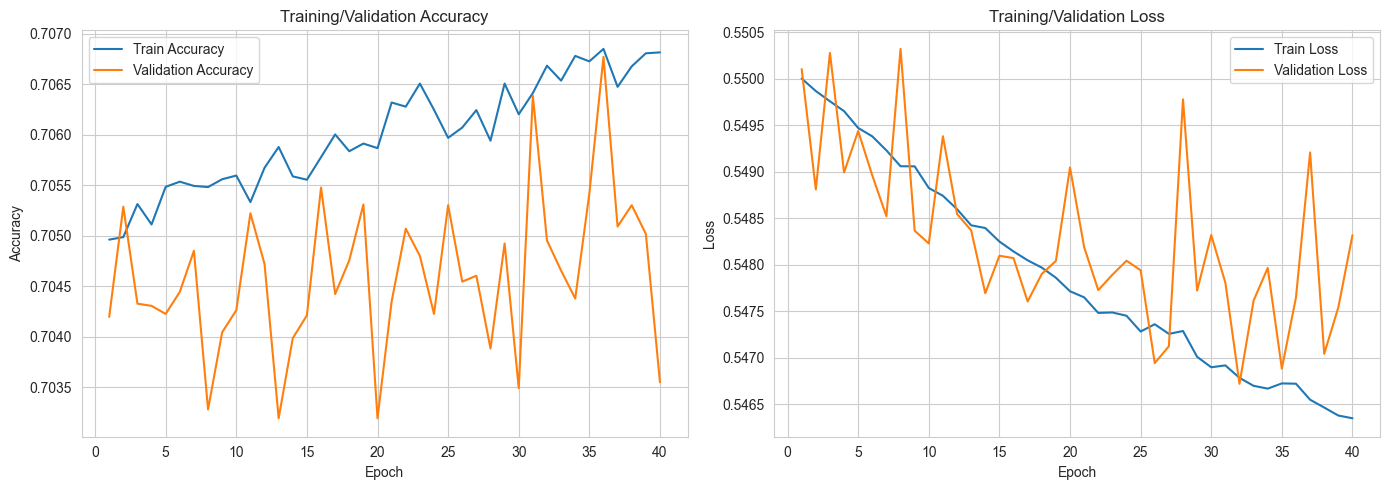

In [20]:
# 9. Plot accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training/Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss')

plt.tight_layout()
plt.show()

In [21]:
# 10. Evaluate on test set
y_pred_prob = model.predict(X_test)
y_pred_int = np.argmax(y_pred_prob, axis=1)
y_test_int = np.argmax(y_test, axis=1)


10739/10739 ━━━━━━━━━━━━━━━━━━━━ 3s 235us/step


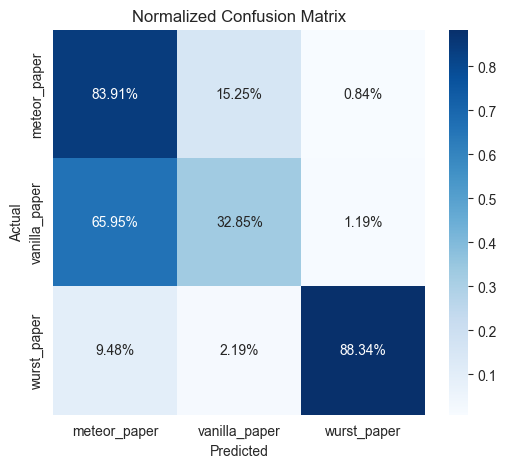

Classification report:
               precision    recall  f1-score   support

 meteor_paper       0.51      0.84      0.64    100750
vanilla_paper       0.64      0.33      0.44    101998
  wurst_paper       0.98      0.88      0.93    140890

     accuracy                           0.71    343638
    macro avg       0.71      0.68      0.67    343638
 weighted avg       0.74      0.71      0.70    343638



In [22]:
# 11. Confusion matrix and classification report
cm = confusion_matrix(y_test_int, y_pred_int)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2%",
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

print("Classification report:")
print(classification_report(y_test_int, y_pred_int, target_names=le.classes_))